# Collatz Conjecture & Happy Numbers — End-to-End Data Science Project


**What this notebook contains (end-to-end):**
- Mathematical background and formulas for Collatz & Happy numbers (what & why)
- Dataset generation (memoized, efficient)
- Exploratory Data Analysis (EDA) and visualizations
- Feature engineering and model training (Random Forest, Logistic Regression)
- Evaluation metrics and model interpretation (feature importances, SHAP)
- Prediction / interactive cells to input any number and get sequence + model outputs
- Exporting datasets & models and notes on GitHub packaging

In [15]:
# CODE
# Run this cell first in Colab. Skip in local if already installed.
!pip install -q scikit-learn pandas joblib shap matplotlib seaborn

## Theory: Collatz Conjecture (3n + 1) and Happy Numbers

### Collatz Conjecture
**Rule (piecewise function):**

$$
f(n) =
\begin{cases}
\dfrac{n}{2} & \text{if } n \text{ is even} \\
3n + 1 & \text{if } n \text{ is odd}
\end{cases}
$$


Repeat by setting n ← f(n) and iterate. The conjecture states that for every positive integer n, iteration eventually reaches the cycle `1 → 4 → 2 → 1`.

**Key measurable properties:**
- *Sequence length* (steps to first reach 1)
- *Peak value* reached during the trajectory
- *Transient behavior* (e.g., initial growth before falling)

Why study with data science:
- Simple rule -> complex behavior (chaotic)
- ML can detect empirical patterns and build predictive models (not proofs)

---

### Happy Numbers
Rule: Replace n by the sum of the squares of its decimal digits repeatedly:

If $n$ has digits $d_1, d_2, \dots, d_k$:

$$
f(n) = d_1^2 + d_2^2 + \dots + d_k^2
$$


Iterate g(n). If you reach 1, n is *happy*. Otherwise it falls into a non-1 cycle and is *unhappy*.

Example: 19 → 1^2 + 9^2 = 82 → 68 → 100 → 1 (happy)

# **Utilities: collatz, happy functions**

In [16]:
# CODE
import math, sys, time
from functools import lru_cache

def collatz_sequence(n, max_steps=10**7):
    """Deterministic Collatz sequence generator. Returns list ending at 1
       or until max_steps to avoid infinite loops."""
    seq = []
    steps = 0
    while n != 1 and steps < max_steps:
        seq.append(n)
        if n % 2 == 0:
            n = n // 2
        else:
            n = 3*n + 1
        steps += 1
    seq.append(n)
    return seq

def is_happy(n, max_iter=1000):
    """Return (is_happy, iterations, cycle_found)."""
    seen = set()
    steps = 0
    while n != 1 and n not in seen and steps < max_iter:
        seen.add(n)
        s = 0
        while n:
            n, d = divmod(n, 10)
            s += d*d
        n = s
        steps += 1
    return (n == 1, steps, (n if n in seen else None))

# **Data generation (memoized Collatz + Happy)**

In [17]:
# CODE
# Efficient generation for Collatz with memoization. Produces CSVs for downstream ML.
import csv
from collections import defaultdict
import pandas as pd
import os
from tqdm import tqdm

def generate_datasets(N=50000, out_dir='data'):
    os.makedirs(out_dir, exist_ok=True)
    collatz_memo = {1: {'steps':0, 'peak':1}}
    collatz_rows = []
    happy_rows = []

    def collatz_stats(n):
        """Return (steps, peak) for starting n using memoization."""
        original = n
        path = []
        peak = n
        steps = 0
        while n != 1 and n not in collatz_memo:
            path.append(n)
            if n % 2 == 0:
                n = n // 2
            else:
                n = 3*n + 1
            peak = max(peak, n)
            steps += 1
        # Use memo if hit
        if n in collatz_memo:
            total_steps = steps + collatz_memo[n]['steps']
            peak = max(peak, collatz_memo[n]['peak'])
        else:
            total_steps = steps
        # backfill
        cur = collatz_memo.get(n, {'steps':0})['steps'] if n in collatz_memo else 0
        for x in reversed(path):
            cur += 1
            collatz_memo[x] = {'steps': cur, 'peak': max(x, peak)}
        return total_steps, peak

    for i in tqdm(range(1, N+1), desc=f"Generating 1..{N}"):
        steps, peak = collatz_stats(i)
        collatz_rows.append({
            'n': i,
            'collatz_steps': steps,
            'collatz_peak': peak,
            'collatz_peak_ratio': float(peak)/i if i>0 else 0,
            'n_bits': i.bit_length(),
            'sum_digits': sum(int(d) for d in str(i)),
            'parity': int(i % 2)
        })
        happy, iters, cyc = is_happy(i)
        happy_rows.append({
            'n': i,
            'is_happy': int(happy),
            'happy_iters': iters,
            'happy_cycle': cyc if cyc is not None else 0,
            'sum_sq_digits': sum(int(d)**2 for d in str(i)),
            'digit_count': len(str(i)),
            'sum_digits': sum(int(d) for d in str(i)),
            'n_mod_3': int(i % 3),
            'n_mod_9': int(i % 9)
        })

    df_collatz = pd.DataFrame(collatz_rows)
    df_happy = pd.DataFrame(happy_rows)
    df_collatz.to_csv(os.path.join(out_dir, 'collatz_dataset.csv'), index=False)
    df_happy.to_csv(os.path.join(out_dir, 'happy_dataset.csv'), index=False)
    return df_collatz, df_happy

# Example run (N can be increased; in Colab you can set higher)
dfc, dfh = generate_datasets(N=50000)
dfc.head(), dfh.head()

Generating 1..50000: 100%|██████████| 50000/50000 [00:01<00:00, 30854.43it/s]


(   n  collatz_steps  collatz_peak  collatz_peak_ratio  n_bits  sum_digits  \
 0  1              0             1            1.000000       1           1   
 1  2              1             2            1.000000       2           2   
 2  3              7            16            5.333333       2           3   
 3  4              2            16            4.000000       3           4   
 4  5              5            16            3.200000       3           5   
 
    parity  
 0       1  
 1       0  
 2       1  
 3       0  
 4       1  ,
    n  is_happy  happy_iters  happy_cycle  sum_sq_digits  digit_count  \
 0  1         1            0            0              1            1   
 1  2         0            9            4              4            1   
 2  3         0           13           37              9            1   
 3  4         0            8            4             16            1   
 4  5         0           12           89             25            1   
 
    sum_dig

# **Quick EDA & Visuals (Code + small explanation)**

Collatz: n range: 1 - 50000
Average steps: 100.50228 Max steps: 323


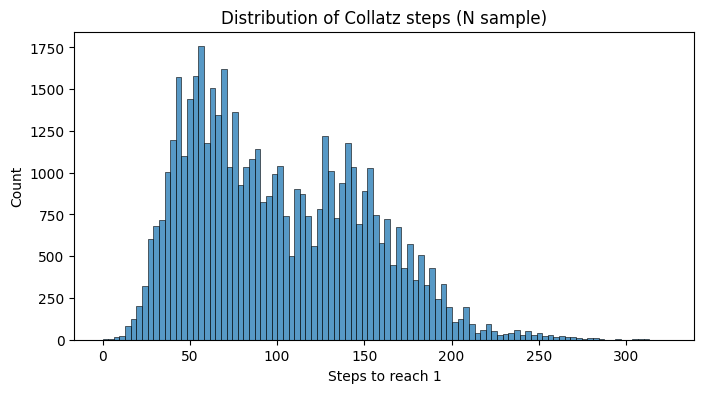

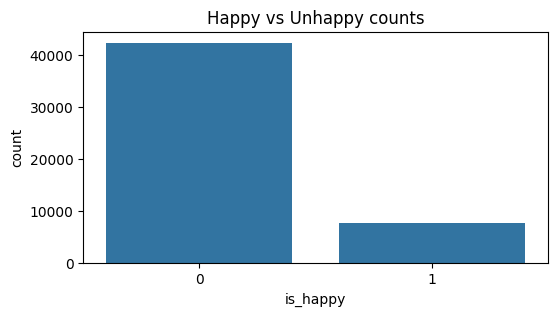

In [18]:
# CODE
import matplotlib.pyplot as plt
import seaborn as sns

# Basic stats
print("Collatz: n range:", dfc['n'].min(), '-', dfc['n'].max())
print("Average steps:", dfc['collatz_steps'].mean(), "Max steps:", dfc['collatz_steps'].max())

# Histogram steps
plt.figure(figsize=(8,4))
sns.histplot(dfc['collatz_steps'], bins=100, kde=False)
plt.title("Distribution of Collatz steps (N sample)")
plt.xlabel("Steps to reach 1")
plt.show()

# Happy distribution
plt.figure(figsize=(6,3))
sns.countplot(x='is_happy', data=dfh)
plt.title("Happy vs Unhappy counts")
plt.show()

# **Feature engineering & train/test split**

In [19]:
# CODE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Collatz features & target
Xc = dfc[['n','collatz_peak_ratio','n_bits','sum_digits','parity']].copy()
yc = dfc['collatz_steps'].copy()

# Log transform to stabilize long tailed target
import numpy as np
yc_log = np.log1p(yc)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc_log, test_size=0.2, random_state=42)
scaler_c = StandardScaler()
Xc_train_s = scaler_c.fit_transform(Xc_train)
Xc_test_s = scaler_c.transform(Xc_test)

# Happy features & target
Xh = dfh[['sum_sq_digits','sum_digits','digit_count','n_mod_3','n_mod_9']].copy()
yh = dfh['is_happy'].copy()
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xh, yh, test_size=0.2, random_state=42)
scaler_h = StandardScaler()
Xh_train_s = scaler_h.fit_transform(Xh_train)
Xh_test_s = scaler_h.transform(Xh_test)

# **Train baseline models (Random Forest + Logistic)**

In [20]:
# CODE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# Collatz regression (predict log-steps)
rfr = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rfr.fit(Xc_train_s, yc_train)
yc_pred_log = rfr.predict(Xc_test_s)
yc_pred = np.expm1(yc_pred_log)
yc_true = np.expm1(yc_test)

rmse = mean_squared_error(yc_true, yc_pred)
r2 = r2_score(yc_true, yc_pred)
print("Collatz regression RMSE:", rmse, "R2:", r2)

# Collatz classification: define 'is_long' using mean+std threshold
threshold = int(dfc['collatz_steps'].mean() + dfc['collatz_steps'].std())
dfc['is_long'] = (dfc['collatz_steps'] > threshold).astype(int)
Xc_cl = dfc[['n','collatz_peak_ratio','n_bits','sum_digits','parity']]
yc_cl = dfc['is_long']

Xc_train_c, Xc_test_c, yc_train_c, yc_test_c = train_test_split(Xc_cl, yc_cl, test_size=0.2, random_state=42)
scaler_cl = StandardScaler()
Xc_train_c_s = scaler_cl.fit_transform(Xc_train_c)
Xc_test_c_s = scaler_cl.transform(Xc_test_c)

rfc = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfc.fit(Xc_train_c_s, yc_train_c)
yc_cl_pred = rfc.predict(Xc_test_c_s)
print("Collatz classifier accuracy:", accuracy_score(yc_test_c, yc_cl_pred),
      "precision:", precision_score(yc_test_c, yc_cl_pred, zero_division=0),
      "recall:", recall_score(yc_test_c, yc_cl_pred, zero_division=0))

# Happy numbers: Logistic + RandomForest
log = LogisticRegression(max_iter=1000)
log.fit(Xh_train_s, yh_train)
yh_pred_log = log.predict(Xh_test_s)
print("Happy Logistic accuracy:", accuracy_score(yh_test, yh_pred_log))

rfc_h = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfc_h.fit(Xh_train_s, yh_train)
yh_pred_rf = rfc_h.predict(Xh_test_s)
print("Happy RF accuracy:", accuracy_score(yh_test, yh_pred_rf),
      "precision:", precision_score(yh_test, yh_pred_rf, zero_division=0))

Collatz regression RMSE: 1941.1869479174538 R2: 0.22204208880791054
Collatz classifier accuracy: 0.816 precision: 0.49479768786127165 recall: 0.23375204806116875
Happy Logistic accuracy: 0.8444
Happy RF accuracy: 0.9996 precision: 0.9993564993564994


# **Save models and datasets**

In [21]:
# CODE
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump({'model': rfr, 'scaler': scaler_c}, 'models/rfr_collatz.joblib')
joblib.dump({'model': rfc, 'scaler': scaler_cl}, 'models/rfc_collatz.joblib')
joblib.dump({'model': log, 'scaler': scaler_h}, 'models/log_happy.joblib')
joblib.dump({'model': rfc_h, 'scaler': scaler_h}, 'models/rfc_happy.joblib')

# Datasets already saved in data/
print("Saved models to models/*.joblib and datasets to data/*.csv")

Saved models to models/*.joblib and datasets to data/*.csv


# **Prediction / Interactive**

In [22]:
# CODE
# Load models and define predict wrapper that mirrors training features
import joblib
models_rfr = joblib.load('models/rfr_collatz.joblib')
models_rfc = joblib.load('models/rfc_collatz.joblib')
models_log = joblib.load('models/log_happy.joblib')
models_rfh = joblib.load('models/rfc_happy.joblib')

rfr_model, rfr_scaler = models_rfr['model'], models_rfr['scaler']
rfc_model, rfc_scaler = models_rfc['model'], models_rfc['scaler']
log_model, log_scaler = models_log['model'], models_log['scaler']
rfh_model, rfh_scaler = models_rfh['model'], models_rfh['scaler']

def make_features_for_collatz(n):
    return [[
        n,
        # placeholder for peak_ratio (unknown before simulation) - use heuristic or 0
        0.0,
        n.bit_length(),
        sum(int(d) for d in str(n)),
        int(n % 2)
    ]]

def make_features_for_happy(n):
    ssd = sum(int(d)**2 for d in str(n))
    return [[ssd, sum(int(d) for d in str(n)), len(str(n)), int(n % 3), int(n % 9)]]

# Interact
num = int(input("Enter a positive integer: "))
# deterministic sequence
seq = collatz_sequence(num)
print(f"Collatz sequence (first 50 items): {seq[:50]}")
print("True steps to 1:", len(seq)-1)

# Predict steps (note: model uses features without real peak_ratio; better to compute partial run features)
Xnum = rfr_scaler.transform(make_features_for_collatz(num))
pred_log = rfr_model.predict(Xnum)[0]
pred_steps = np.expm1(pred_log)
print("Predicted steps (approx):", int(pred_steps))

# Predict long/short using classifier
Xnum_c = rfc_scaler.transform(make_features_for_collatz(num))
pred_long = rfc_model.predict_proba(Xnum_c)[0,1]
print(f"Predicted probability of 'long' sequence: {pred_long:.3f}")

# Happy predictions
Xh_num = log_scaler.transform(make_features_for_happy(num))
print("Logistic predicts happy?:", bool(log_model.predict(Xh_num)[0]))
Xh_num2 = rfh_scaler.transform(make_features_for_happy(num))
print("RandomForest predicts happy?:", bool(rfh_model.predict(Xh_num2)[0]))

Enter a positive integer: 20
Collatz sequence (first 50 items): [20, 10, 5, 16, 8, 4, 2, 1]
True steps to 1: 7
Predicted steps (approx): 7
Predicted probability of 'long' sequence: 0.000
Logistic predicts happy?: False
RandomForest predicts happy?: False


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# **Model explanation with SHAP**

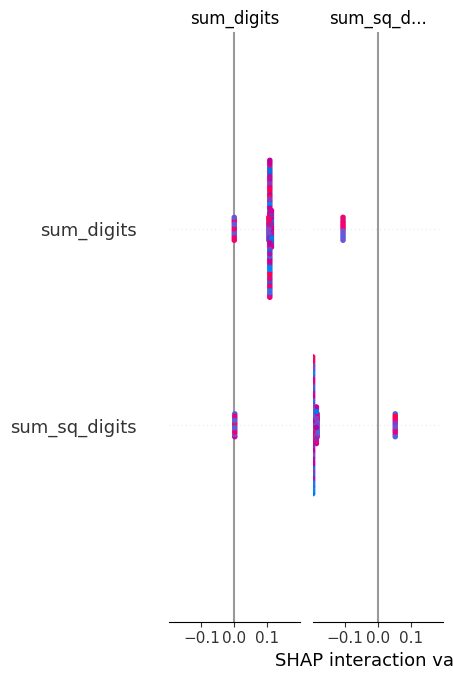

In [23]:
# CODE
# SHAP explanation for the RandomForest on Happy numbers (fast)
import shap
explainer = shap.TreeExplainer(rfc_h)
# sample some inputs
sample_X = Xh_train.sample(100, random_state=42)
shap_values = explainer.shap_values(sample_X)
# Visual (force plot requires JS; use summary_plot)
shap.summary_plot(shap_values, sample_X, show=True)

# **Notes on scaling, deep learning, and LLM ideas**

## Scaling & Advanced Ideas (what & why & how)

### Scale to N = 1e6 or more
- Use Dask or PySpark for distributed computation of Collatz stats.
- Use integer/bitwise optimizations; avoid Python loops if possible (Cython or Rust for speed).

### Deep Learning / Sequence Models
- Frame as sequence-to-value: feed the first K terms to an LSTM/Transformer to predict final length or peak.
- Use padding/truncation and masking. Requires GPU and careful normalization.

### LLMs & Pattern Discovery
- LLMs are not suitable for numeric exact prediction, but they can:
  - Summarize patterns found by ML.
  - Generate natural-language explanations of model output.
  - Assist in writing hypothesis text, detecting anomalies in results.

### Research vs ML
- ML does NOT prove mathematical conjectures - treat results as exploratory evidence, not proof.